In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (confusion_matrix, precision_score, recall_score,
                            f1_score, roc_auc_score, auc, precision_recall_curve,
                            matthews_corrcoef, mean_squared_error)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Set random state
RANDOM_STATE = 778
np.random.seed(RANDOM_STATE)

In [23]:
data = pd.read_csv('data/final_data/final_data.csv')

In [24]:
### Functions to be used throughout notebook
# Preprocess the data
def preprocess_data(df):
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()

    # Convert timestamp and ensure dates are sorted
    df['event_date'] = pd.to_datetime(df['event_date'])
    df = df.sort_values('event_date').reset_index(drop=True)

    # One-hot encode categorical columns
    categorical_cols = ['vessel_info_flag', 'event_info_origin_port.iso', 'event_info_destination_port.iso']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Define features and target
    target = 'extended_loitering'
    features = df.columns.difference([target, 'event_date'])

    # Remove multicollinearity
    corr_matrix = df[features].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
    features = features.difference(to_drop)
    df = df.drop(columns=to_drop)

    return df, features, target


# Model Evaluation metrics
def evaluate_model(y_true, y_pred, y_pred_proba):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'pr_auc': average_precision_score(y_true, y_pred_proba)
    }
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    return metrics, conf_matrix


# Preprocess data
df_processed, features, target = preprocess_data(data)

## Initial Model Evaluation

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           Logistic Regression  Decision Tree  Random Forest   
accuracy              0.760603       0.850781       0.904464  \
precision             0.206383       0.188584       0.500000   
recall                0.532224       0.172289       0.003689   
f1                    0.297309       0.179548       0.007317   
pr_auc                0.222914       0.112429       0.272704   

           Gradient Boosting       KNN  
accuracy            0.903348  0.898549  
precision           0.479424  0.326444  
recall              0.081918  0.053434  
f1                  0.139619  0.090412  
pr_auc              0.294817  0.158866  


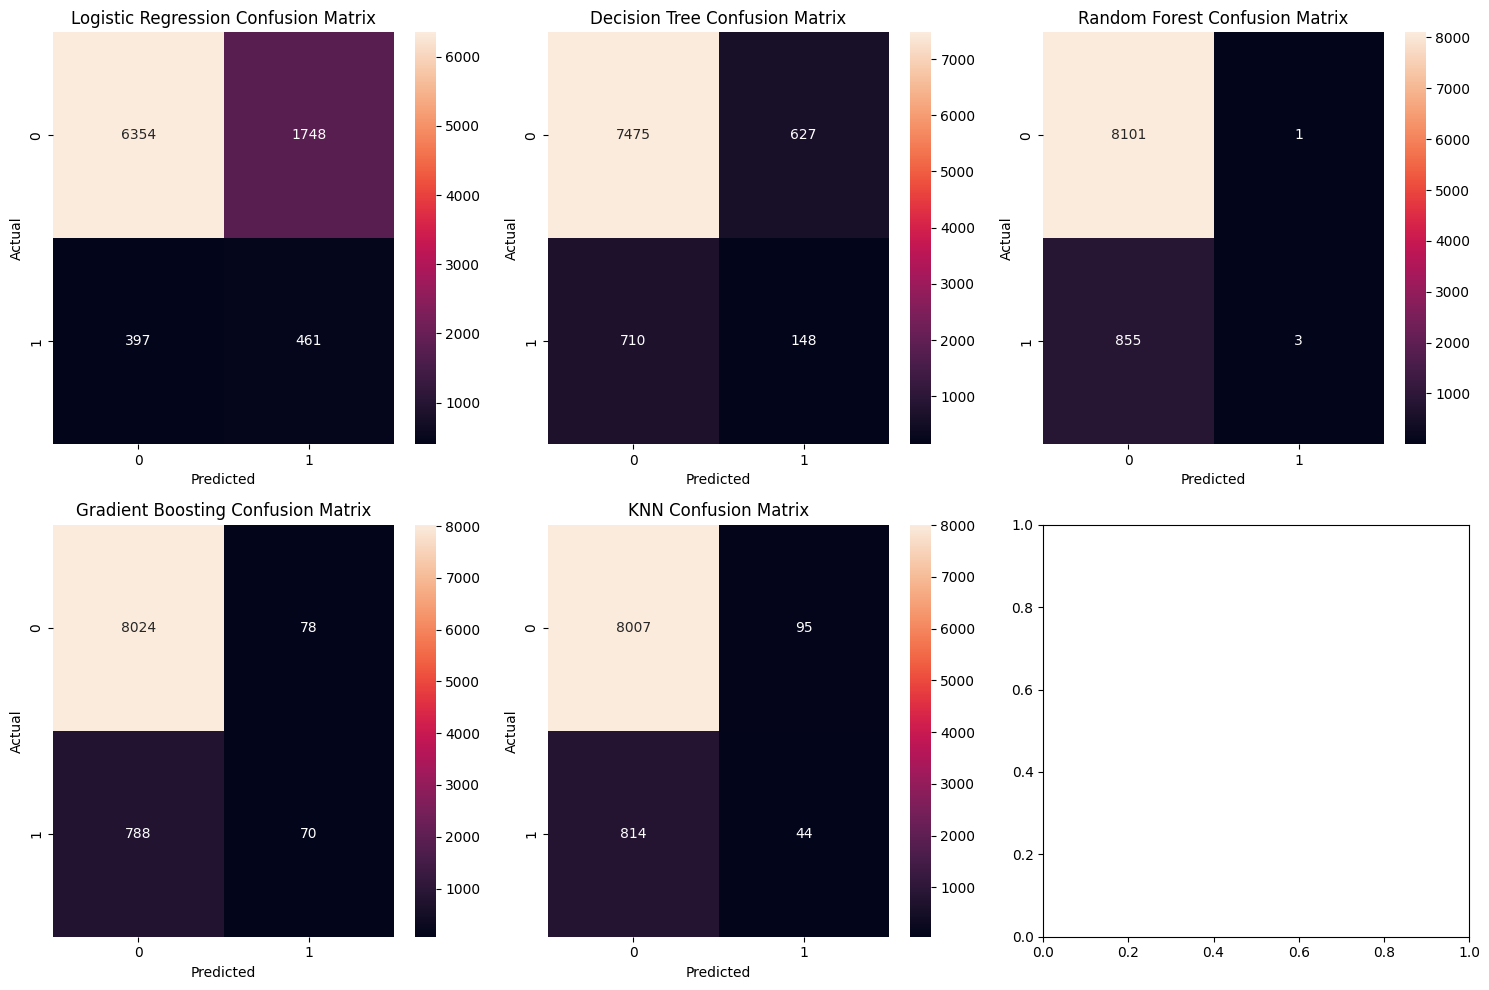

In [25]:
# Model training and evaluation function
def train_and_evaluate_models(df, features, target, n_splits=5):
    # Initialize TimeSeriesSplit with custom parameters
    tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=None)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
        'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=RANDOM_STATE),
        'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }

    # Prepare data
    X = df[features].values
    y = df[target].values

    # Store results
    results = {model_name: [] for model_name in models.keys()}
    confusion_matrices = {model_name: np.zeros((2, 2)) for model_name in models.keys()}

    # Perform cross-validation
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Scale features within the fold
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        for model_name, model in models.items():
            # Train model
            model.fit(X_train_scaled, y_train)

            # Make predictions
            y_pred = model.predict(X_val_scaled)
            y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]

            # Calculate metrics
            metrics, conf_matrix = evaluate_model(y_val, y_pred, y_pred_proba)
            results[model_name].append(metrics)
            confusion_matrices[model_name] += conf_matrix

    # Average results across folds
    final_results = {}
    for model_name in models.keys():
        model_metrics = pd.DataFrame(results[model_name])
        final_results[model_name] = model_metrics.mean()

    return final_results, confusion_matrices


# Function to plot confusion matrices
def plot_confusion_matrices(confusion_matrices):
    n_models = len(confusion_matrices)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, (model_name, conf_matrix) in enumerate(confusion_matrices.items()):
        if idx < len(axes):
            sns.heatmap(conf_matrix, annot=True, fmt='g', ax=axes[idx])
            axes[idx].set_title(f'{model_name} Confusion Matrix')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    return fig


# Train and evaluate models
results, confusion_matrices = train_and_evaluate_models(df_processed, features, target)

results_df = pd.DataFrame(results)

print(results_df)

fig = plot_confusion_matrices(confusion_matrices)

## Model Refining - Iteration 1: CV split adjustments with fixed params for RandomizedSearchCV


Getting best XGBoost model with 3 CV splits...
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best parameters for 3 CV splits:
subsample: 0.9
scale_pos_weight: 1
n_estimators: 700
min_child_weight: 4
max_depth: 3
learning_rate: 0.01
gamma: 1.5
colsample_bytree: 0.8

Model Performance Metrics:
accuracy     0.905878
precision    0.777536
recall       0.058440
f1           0.108485
pr_auc       0.340998
dtype: float64

Getting best XGBoost model with 5 CV splits...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters for 5 CV splits:
subsample: 0.9
scale_pos_weight: 1
n_estimators: 700
min_child_weight: 4
max_depth: 3
learning_rate: 0.01
gamma: 1.5
colsample_bytree: 0.8

Model Performance Metrics:
accuracy     0.908482
precision    0.801717
recall       0.060897
f1           0.111901
pr_auc       0.321857
dtype: float64

Getting best XGBoost model with 7 CV splits...
Fitting 7 folds for each of 100 candidates, totalling 700 fits

Best parameter

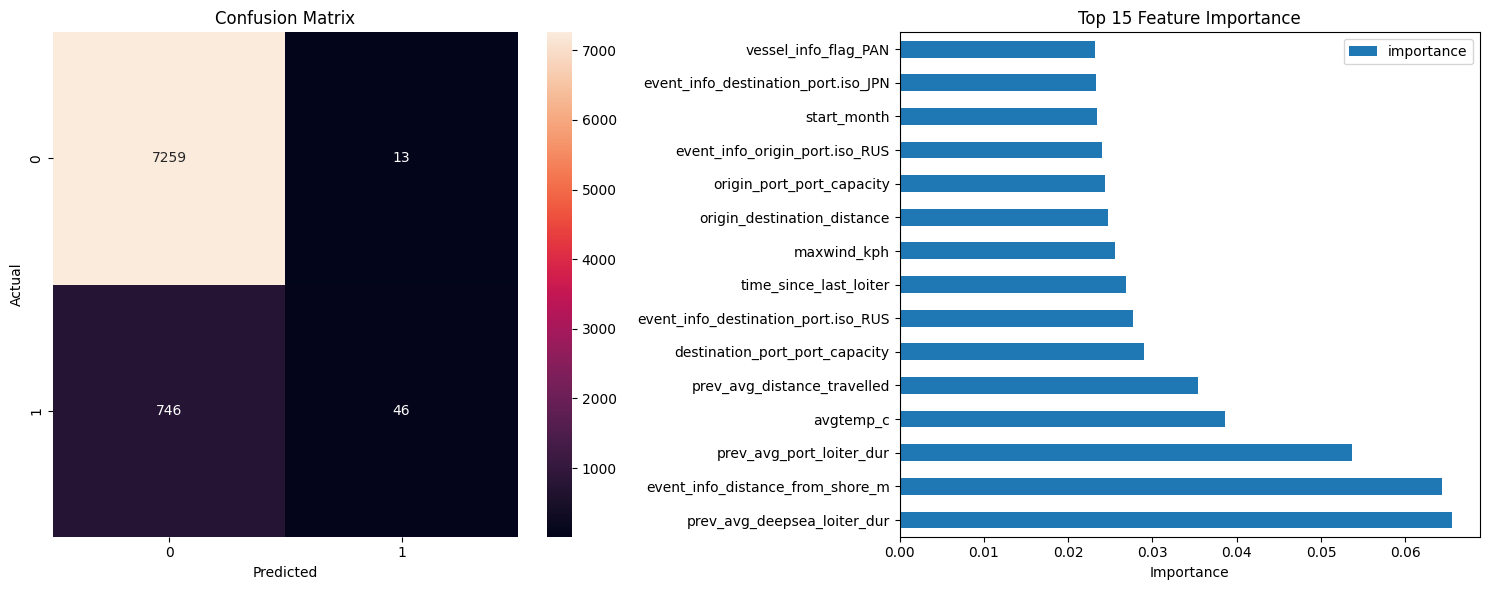

In [47]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, average_precision_score,
                           confusion_matrix)


def xgb_model(df, features, target, n_splits=5, n_iter=100):
    """
    Optimize Gradient Boosting model using RandomizedSearchCV with time series split.
    """
    # Prepare data
    X = df[features].values
    y = df[target].values

    # Define parameter space
    param_distributions = {
        'classifier__n_estimators': [100, 300, 500, 700, 900],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'classifier__max_depth': [3, 4, 5, 6, 7, 8, 10],
        'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'classifier__scale_pos_weight': [1, 10, 25, 50, 75, 100],
        'classifier__gamma': [0, 0.1, 0.2, 0.5, 1, 1.5, 2],
        'classifier__min_child_weight': [1, 2, 3, 4, 5],
    }

    pipeline = Pipeline([
        ('classifier', XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'))
    ])

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='average_precision',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )

    # Fit RandomizedSearchCV
    random_search.fit(X, y)

    return random_search.best_estimator_, random_search.best_params_


def evaluate_optimized_model(model, df, features, target, n_splits=5, threshold=0.5):
    """
    Lower threshold will increase recall (catch more actual extended loitering events), but decrease precision (more false positive)
    """
    X = df[features].values
    y = df[target].values

    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []
    confusion_matrices = np.zeros((2, 2))
    feature_importances = []

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Scaling not needed for XGBoost
        X_train_scaled = X_train
        X_val_scaled = X_val

        # Fit the model
        model.fit(X_train_scaled, y_train)

        # Collect feature importances
        classifier = model.named_steps['classifier']
        feature_importances.append(classifier.feature_importances_)

        # Get probability predictions first
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        
        # Apply custom threshold to probabilities
        y_pred = (y_pred_proba >= threshold).astype(int)

        metrics, conf_matrix = evaluate_model(y_val, y_pred, y_pred_proba)
        results.append(metrics)
        confusion_matrices += conf_matrix

    # Average metrics across folds
    avg_metrics = pd.DataFrame(results).mean()

    # Average feature importances across folds
    avg_feature_importance = np.mean(feature_importances, axis=0)
    feature_importance_df = pd.DataFrame(
        avg_feature_importance,
        index=features,
        columns=['importance']
    ).sort_values('importance', ascending=False)

    return avg_metrics, confusion_matrices, feature_importance_df


def plot_results(confusion_matrix, feature_importance):
    """
    Plot confusion matrix and feature importance.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot confusion matrix
    sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # Plot top 15 feature importance
    feature_importance.head(15).plot(kind='barh', ax=ax2)
    ax2.set_title('Top 15 Feature Importance')
    ax2.set_xlabel('Importance')

    plt.tight_layout()
    return fig


best_split_data = {'pr_auc': 0, 'splits': None, 'metrics': None, 'conf_matrix': None, 'feature_importance': None}

for splits in [3, 5, 7, 10]:
    print(f"\nGetting best XGBoost model with {splits} CV splits...")
    best_model, best_params = xgb_model(df_processed, features, target, n_splits=splits)
    
    print(f"\nBest parameters for {splits} CV splits:")
    for param, value in best_params.items():
        print(f"{param.replace('classifier__', '')}: {value}")
    
    metrics, conf_matrix, feature_importance = evaluate_optimized_model(
        best_model, df_processed, features, target, n_splits=splits, threshold=0.5)
    
    current_pr_auc = metrics.get('pr_auc', 0)
    if current_f1 > best_split_data['pr_auc']:
        best_split_data.update({
            'pr_auc': current_pr_auc,
            'splits': splits,
            'metrics': metrics,
            'conf_matrix': conf_matrix,
            'feature_importance': feature_importance
        })
    
    print("\nModel Performance Metrics:")
    print(metrics)

# Display and plot the results for the best split
print("\nBest Split Based on pr_auc Score:")
print(f"Number of CV Splits: {best_split_data['splits']}")

print("Best Model Performance Metrics:")
print(best_split_data['metrics'])

fig = plot_results(best_split_data['conf_matrix'], best_split_data['feature_importance'])
plt.show()


## Model Refining - Iteration 2: Recursive Feature Elimination

Performing Recursive Feature Elimination analysis with optimized parameters...
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Testing feature set size: 10

Testing feature set size: 15

Testing feature set size: 20

Testing feature set size: 30

Testing feature set size: 50

Testing feature set size: 75

Testing feature set size: 100

Best feature set results:
Number of features: 30

RFE Adjusted Model Performance Metrics:
accuracy: 0.906250
precision: 0.805556
recall: 0.061463
f1: 0.113789
pr_auc: 0.346058


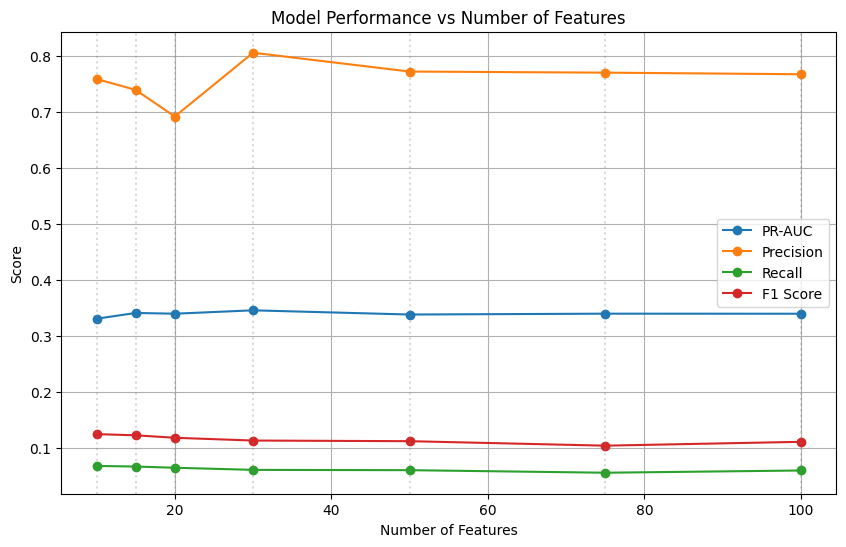

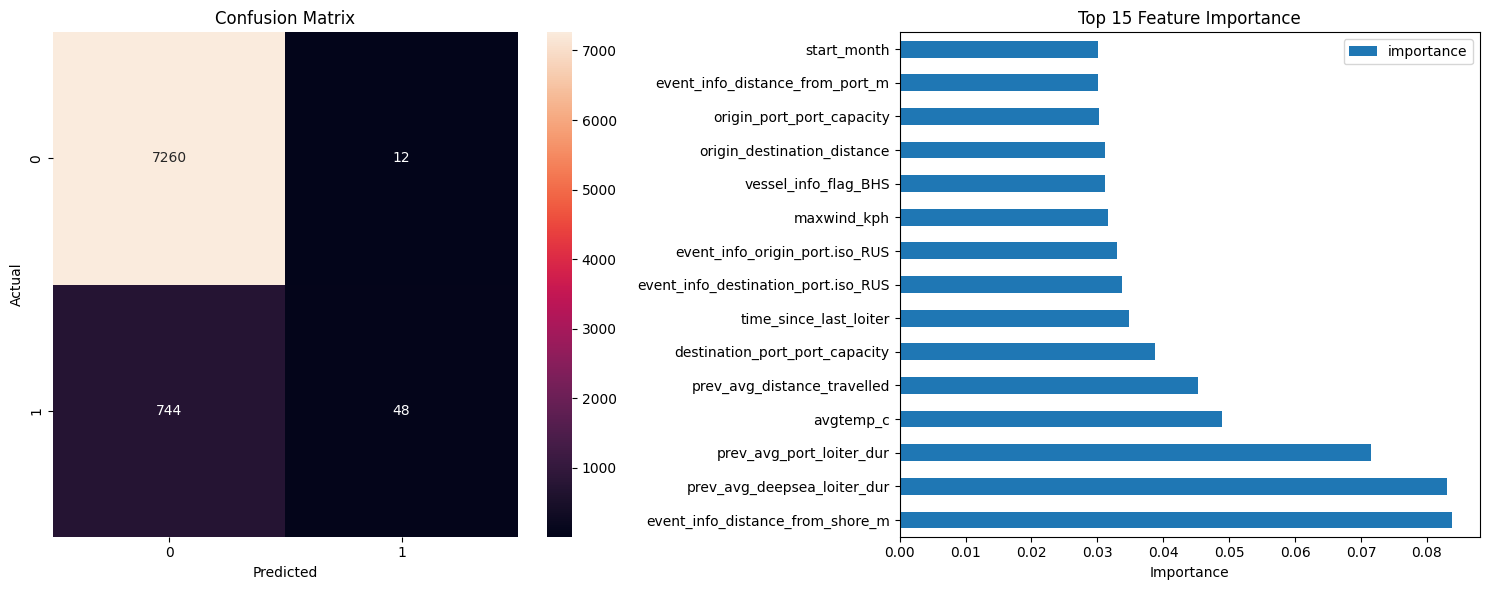

In [52]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optimized CV splits
CV_SPLITS = 3

def clean_params(best_params):
    """
    Remove 'classifier__' prefix from parameter names.
    """
    return {
        k.replace('classifier__', ''): v 
        for k, v in best_params.items()
    }
    
def perform_rfe_analysis(df, features, target, n_features_list):
    """
    Perform RFE analysis with different feature set sizes using optimized XGBoost parameters.
    """
    X = df[features].values
    y = df[target].values

    best_model, best_params = xgb_model(df_processed, features, target, n_splits=CV_SPLITS)

    cleaned_params = clean_params(best_params)
    
    # Initialize RFE classifier
    base_classifier = XGBClassifier(random_state=RANDOM_STATE, **cleaned_params)
    
    results = []
    
    for n_features in n_features_list:
        print(f"\nTesting feature set size: {n_features}")
        
        # Perform RFE with base classifier
        rfe = RFE(estimator=base_classifier, 
                  n_features_to_select=n_features, 
                  step=1)
        rfe.fit(X, y)
        
        # Get selected features
        selected_features = [f for f, selected in zip(features, rfe.support_) if selected]
        
        # Create pipeline with selected features
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', XGBClassifier(random_state=RANDOM_STATE, **cleaned_params))
        ])
        
        # Evaluate model
        metrics, conf_matrix, feature_imp = evaluate_optimized_model(
            pipeline, df, selected_features, target, n_splits=CV_SPLITS, threshold=0.5)
        
        results.append({
            'n_features': n_features,
            'selected_features': selected_features,
            'metrics': metrics,
            'confusion_matrix': conf_matrix,
            'feature_importance': feature_imp
        })
        
    return results

def plot_rfe_results(rfe_results):
    """
    Plot metrics across different feature set sizes.
    """
    n_features = [r['n_features'] for r in rfe_results]
    pr_auc = [r['metrics']['pr_auc'] for r in rfe_results]
    precisions = [r['metrics']['precision'] for r in rfe_results]
    recalls = [r['metrics']['recall'] for r in rfe_results]
    f1_scores = [r['metrics']['f1'] for r in rfe_results]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(n_features, pr_auc, marker='o', label='PR-AUC')
    ax.plot(n_features, precisions, marker='o', label='Precision')
    ax.plot(n_features, recalls, marker='o', label='Recall')
    ax.plot(n_features, f1_scores, marker='o', label='F1 Score')
    
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance vs Number of Features')
    ax.legend()
    ax.grid(True)
    
    # Add vertical lines at each data point for easier reading
    for x in n_features:
        ax.axvline(x=x, color='gray', linestyle=':', alpha=0.3)
    
    return fig

# Example usage
n_features = [10, 15, 20, 30, 50, 75, 100]
print("Performing Recursive Feature Elimination analysis with optimized parameters...")
rfe_results = perform_rfe_analysis(df_processed, features, target, n_features)

# Find best feature set based on PR-AUC score
best_result = max(rfe_results, key=lambda x: x['metrics']['pr_auc'])
print("\nBest feature set results:")
print(f"Number of features: {best_result['n_features']}")

print("\nRFE Adjusted Model Performance Metrics:")
for metric, value in best_result['metrics'].items():
    print(f"{metric}: {value:.6f}")

# Plot results
fig_metrics = plot_rfe_results(rfe_results)
plt.show()

# Plot confusion matrix and feature importance for best model
fig_results = plot_results(
    best_result['confusion_matrix'],
    best_result['feature_importance']
)
plt.show()

## Model Refining - Iteration 3: Parameter Adjustment
Adjusting model parameters by using wider range for Randmonized CV Search

Getting Parameter adjusted XGBoost model...
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best parameters found:
colsample_bytree: 0.6060169438814165
gamma: 4.8115455154726305
learning_rate: 0.03077903007913945
max_depth: 10
min_child_weight: 1
n_estimators: 496
reg_alpha: 0.9272985613076892
reg_lambda: 10.712859317462081
scale_pos_weight: 9.699502487562189
subsample: 0.8843553051814872

Evaluating optimized model...
Parameter adjusted Model Performance Metrics:
accuracy     0.852679
precision    0.274315
recall       0.348791
f1           0.304017
pr_auc       0.311853
dtype: float64


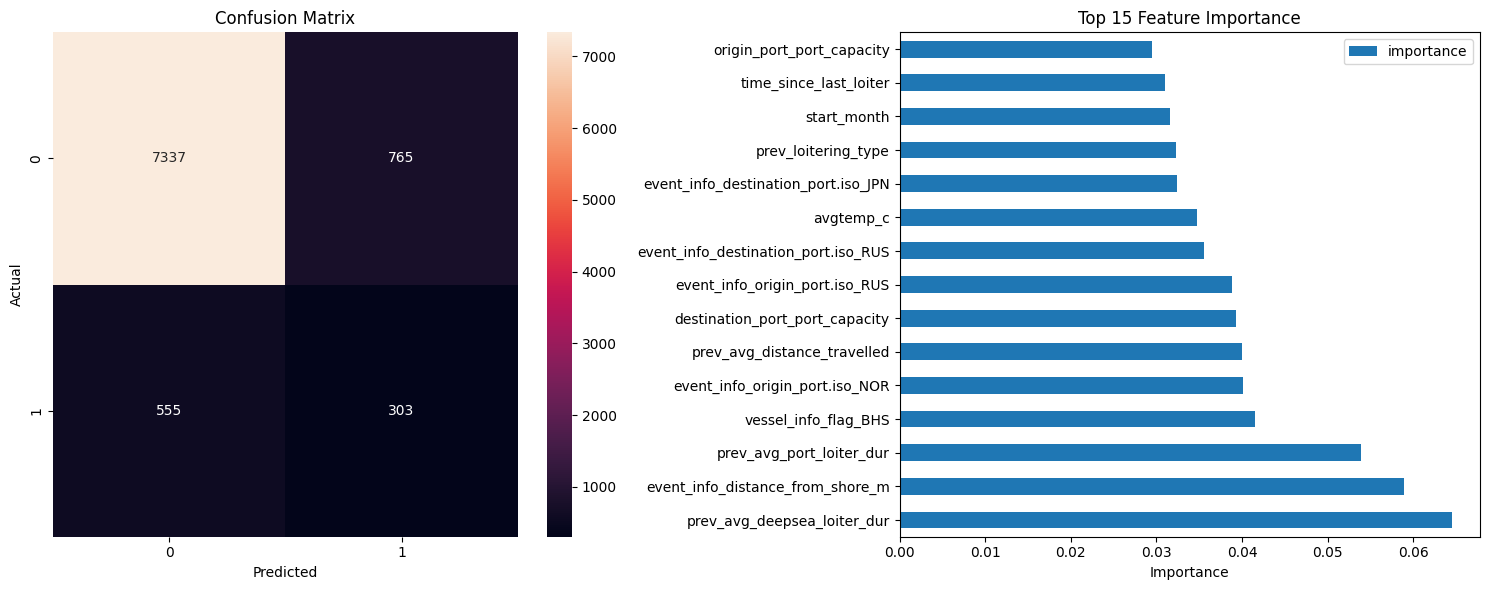

In [61]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, average_precision_score,
                           confusion_matrix)


def adjusted_xgb_model(df, features, target, n_splits=CV_SPLITS, n_iter=100):
    """
    Adjusted parameters of Gradient Boosting model
    """
    # Prepare data
    X = df[features].values
    y = df[target].values

    # Define parameter space
    param_distributions = {
        'classifier__n_estimators': randint(100, 1000),               # Number of boosting rounds
        'classifier__learning_rate': uniform(0.01, 0.3),              # Step size shrinkage
        'classifier__max_depth': randint(3, 15),                      # Maximum tree depth
        'classifier__subsample': uniform(0.5, 0.5),                   # Subsample ratio of the training data
        'classifier__colsample_bytree': uniform(0.5, 0.5),            # Subsample ratio of columns
        'classifier__scale_pos_weight': [float(np.sum(y == 0)) / np.sum(y == 1)], # Class weight scaling
        'classifier__gamma': uniform(0, 5),                           # Minimum loss reduction to split
        'classifier__min_child_weight': randint(1, 10),               # Minimum sum of instance weight
        'classifier__reg_alpha': uniform(0, 1),                       # L1 regularization term
        'classifier__reg_lambda': uniform(1, 10)                      # L2 regularization term
}

    pipeline = Pipeline([
        ('classifier', XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'))
    ])

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='average_precision',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )

    # Fit RandomizedSearchCV
    random_search.fit(X, y)

    return random_search.best_estimator_, random_search.best_params_
    

# After getting best_model:
print("Getting Parameter adjusted XGBoost model...")
best_model, best_params = adjusted_xgb_model(df_processed, best_result['selected_features'], target)

print("\nBest parameters found:")
for param, value in best_params.items():
    clean_param = param.replace('classifier__', '')
    print(f"{clean_param}: {value}")

print("\nEvaluating optimized model...")
metrics, conf_matrix, feature_importance = evaluate_optimized_model(
    best_model, 
    df_processed, 
    best_result['selected_features'], 
    target,
    threshold=0.5
)

# Display final results
print("Parameter adjusted Model Performance Metrics:")
print(metrics)

# Plot final results
fig = plot_results(conf_matrix, feature_importance)
plt.show()

## Model Refining - Iteration 4: Decision Threshold Tests

Optimizing XGBoost model...
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best parameters found:
colsample_bytree: 0.6060169438814165
gamma: 4.8115455154726305
learning_rate: 0.03077903007913945
max_depth: 10
min_child_weight: 1
n_estimators: 496
reg_alpha: 0.9272985613076892
reg_lambda: 10.712859317462081
scale_pos_weight: 9.699502487562189
subsample: 0.8843553051814872

Results for different thresholds (metrics by threshold):
     accuracy  precision    recall        f1    pr_auc
0.3  0.740179   0.209139  0.618758  0.311088  0.311853
0.4  0.808036   0.238002  0.468945  0.313645  0.311853
0.5  0.852679   0.274315  0.348791  0.304017  0.311853
0.6  0.885491   0.345248  0.242081  0.281457  0.311853
0.7  0.901228   0.447689  0.149873  0.219889  0.311853


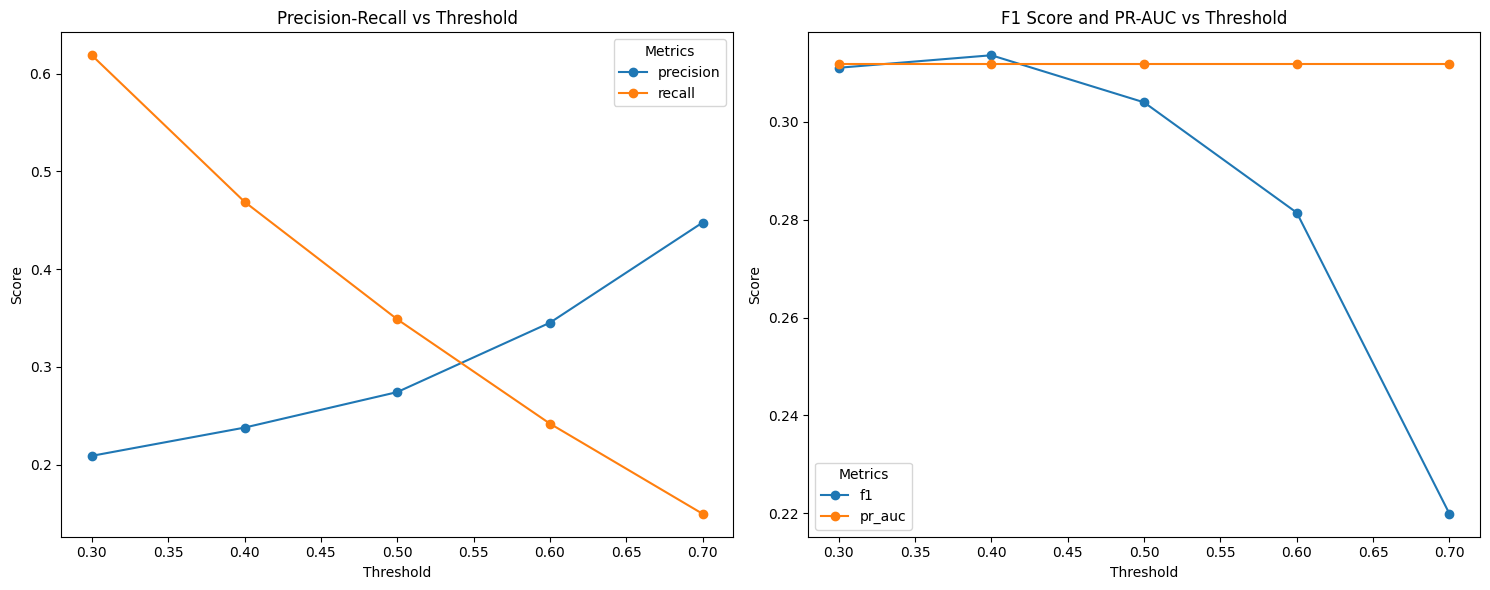

In [62]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, average_precision_score,
                           confusion_matrix)

# After getting best_model:
print("Optimizing XGBoost model...")
best_model, best_params = adjusted_xgb_model(df_processed, best_result['selected_features'], target)

print("\nBest parameters found:")
for param, value in best_params.items():
    clean_param = param.replace('classifier__', '')
    print(f"{clean_param}: {value}")

# Decision Threshold testing range
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = {}

for threshold in thresholds:
    metrics, conf_matrix, feature_importance = evaluate_optimized_model(
        best_model, 
        df_processed, 
        best_result['selected_features'], 
        target,
        threshold=threshold
    )
    threshold_results[threshold] = {
        'metrics': metrics,
        'confusion_matrix': conf_matrix
    }

# Convert threshold results to a DataFrame for cleaner printing and plotting
threshold_metrics_df = pd.DataFrame({
    threshold: results['metrics'] for threshold, results in threshold_results.items()
}).T
print("\nResults for different thresholds (metrics by threshold):")
print(threshold_metrics_df)

# Plot threshold metrics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Precision-Recall trade-off
threshold_metrics_df[['precision', 'recall']].plot(ax=ax1, marker='o')
ax1.set_title('Precision-Recall vs Threshold')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.legend(title="Metrics")

# F1 Score and MCC
threshold_metrics_df[['f1', 'pr_auc']].plot(ax=ax2, marker='o')
ax2.set_title('F1 Score and PR-AUC vs Threshold')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score')
ax2.legend(title="Metrics")

plt.tight_layout()
plt.show()


Evaluating optimized model with best threshold...

Optimized Model Performance Metrics (with best threshold):
accuracy     0.808036
precision    0.238002
recall       0.468945
f1           0.313645
pr_auc       0.311853
dtype: float64


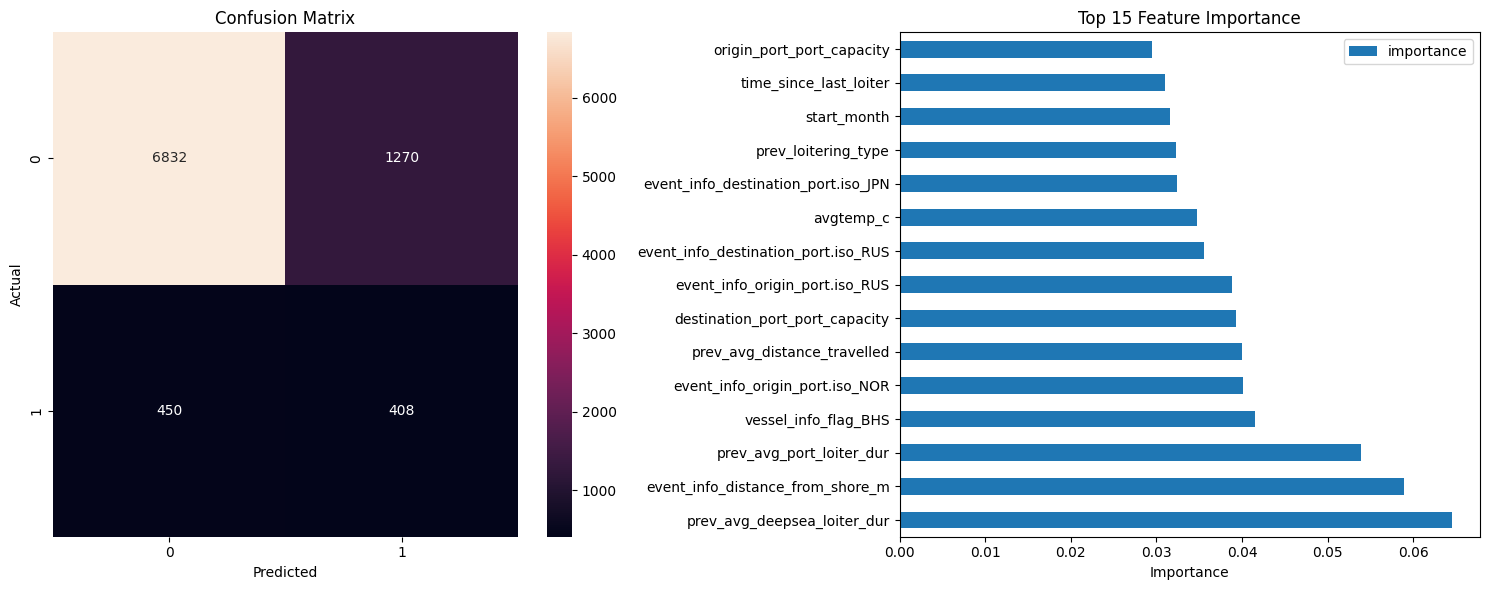

In [64]:
print("\nEvaluating optimized model with best threshold...")
metrics, conf_matrix, feature_importance = evaluate_optimized_model(
    best_model, 
    df_processed, 
    best_result['selected_features'], 
    target,
    threshold=0.4)

print("\nOptimized Model Performance Metrics (with best threshold):")
print(metrics)

fig = plot_results(conf_matrix, feature_importance)
plt.show()